# Init Library

In [11]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

from scipy import signal, fftpack
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Activation, Dropout
from keras import utils
utils.to_categorical

from tensorflow.keras.utils import to_categorical

# Load directory

In [12]:
load = "C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM"
save = "C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Img"
proc_30 = 'C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/30%/*.csv'
proc_50 = 'C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/50%/*.csv'
proc_70 = 'C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/70%/*.csv'
proc_90 = 'C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/90%/*.csv'
combine = 'C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/Comb/*.csv'

# Parameter

In [13]:
lowcut = 0.5
highcut = 5.0
fs = 100.0
order = 5

# Apply Parameter

In [20]:
files_csv =[]
for root, dirs, files in os.walk(load):
    for file_name in files:
        if file_name.endswith(".csv"):
            file_load = os.path.join(root, file_name)
            files_csv.append(file_load)

In [21]:
i = 0

for file_csv in files_csv:
   
    df_uncut = pd.read_csv(file_csv)
    start_index = 1
    end_index = 1551
    df = df_uncut[start_index:end_index]
    var = df['X'].values
    data = df['Y'].values
     
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    
    #Filter bandpass
    filtered_signal = signal.filtfilt(b, a, data)
    
    # Rectify signal
    rectified_signal = np.abs(filtered_signal)
    
    # One-sided FFT
    signal_fft = np.fft.fft(filtered_signal)
    signal_freq = np.fft.fftfreq(len(filtered_signal), 1/fs)
    n = len(filtered_signal)
    freq = signal_freq[0:int(n/2)]
    fft_amp = np.abs(signal_fft)[0:int(n/2)]/n*2
    
    # One-sided PSD
    psd = (1/(fs*n)) * np.square(np.abs(signal_fft[:n//2]))
    freq_psd = signal_freq[0:int(n/2)]
    psd_one_side = psd[0:int(n/2)]
    
    processed_csv_file = file_csv.replace(".csv", "_processed.csv")
    df.to_csv(processed_csv_file, index=False)
    
    # fig, axs = plt.subplots(2, 2, figsize=(10,10))

    # axs[0, 0].plot(var, filtered_signal)
    # axs[0, 0].set_title(file_csv)
    # axs[0, 0].set_xlabel('Time (us)')
    # axs[0, 0].set_ylabel('Amplitude (V)')

    # axs[0, 1].plot(var, rectified_signal)
    # axs[0, 1].set_title(file_csv)
    # axs[0, 1].set_xlabel('Time (us)')
    # axs[0, 1].set_ylabel('Amplitude (V)')

    # axs[1, 0].plot(freq, fft_amp)
    # axs[1, 0].set_title(file_csv)
    # axs[1, 0].set_xlabel('Frequency (MHz)')
    # axs[1, 0].set_ylabel('Amplitude Power/Frequency (dB/Hz)')

    # axs[1, 1].plot(freq_psd, psd_one_side)
    # axs[1, 1].set_title(file_csv)
    # axs[1, 1].set_xlabel('Frequency (MHz)')
    # axs[1, 1].set_ylabel('Power/Frequency (dB/Hz)')

    # save_img = file_csv+".png"
    # plt.savefig(save_img)


# Move PSD to New Folder

In [22]:
os.chdir(load)
if not os.path.exists(load+"Process"):
        os.makedirs(load+"Process")
        print("'data' folder created")
        
for root, dirs, files in os.walk(load):
        for filename in files:
            if filename.endswith("_processed.csv"):
                original_file = os.path.join(root, filename)                
                if not "Process/" in original_file:
                    print("Moved '",original_file," to ","./Process/"+filename)
                    os.rename(original_file, "./Process/"+filename)

Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\data_predict_predicted_processed.csv  to  ./Process/data_predict_predicted_processed.csv
Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\30%\A301_processed.csv  to  ./Process/A301_processed.csv
Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\30%\A302_processed.csv  to  ./Process/A302_processed.csv
Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\30%\A303_processed.csv  to  ./Process/A303_processed.csv
Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\30%\A304_processed.csv  to  ./Process/A304_processed.csv
Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\30%\A305_processed.csv  to  ./Process/A305_processed.csv
Moved ' C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM\30%\K301_processed.csv  to  ./P

# Gabungkan Dataset menjadi satu

In [23]:
# Menggunakan glob untuk mendapatkan daftar file CSV
csv_files = glob.glob(proc_30)

# Membuat list kosong untuk menyimpan DataFrame dari setiap file CSV
dataframes = []

# Menggabungkan semua file CSV menjadi satu DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Menggabungkan DataFrame dalam list menjadi satu DataFrame utama
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/Comb/1.csv', index=True)
# combined_df.to_csv('E:/Sekolah/Telkom/TA/LTSM/Process/Comb/1.csv', index=False)

In [24]:
# Menggunakan glob untuk mendapatkan daftar file CSV
csv_files = glob.glob(proc_50)

# Membuat list kosong untuk menyimpan DataFrame dari setiap file CSV
dataframes = []

# Menggabungkan semua file CSV menjadi satu DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Menggabungkan DataFrame dalam list menjadi satu DataFrame utama
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/Comb/2.csv', index=True)

In [25]:
# Menggunakan glob untuk mendapatkan daftar file CSV
csv_files = glob.glob(proc_70)

# Membuat list kosong untuk menyimpan DataFrame dari setiap file CSV
dataframes = []

# Menggabungkan semua file CSV menjadi satu DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Menggabungkan DataFrame dalam list menjadi satu DataFrame utama
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/Comb/3.csv', index=True)

In [26]:
# Menggunakan glob untuk mendapatkan daftar file CSV
csv_files = glob.glob(proc_90)

# Membuat list kosong untuk menyimpan DataFrame dari setiap file CSV
dataframes = []

# Menggabungkan semua file CSV menjadi satu DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Menggabungkan DataFrame dalam list menjadi satu DataFrame utama
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/Comb/4.csv', index=True)

In [27]:
merge = 'C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/Comb/All.csv'

# Menggunakan glob untuk mendapatkan daftar file CSV
csv_files = glob.glob(combine)

# Membuat list kosong untuk menyimpan DataFrame dari setiap file CSV
dataframes = []

# Menggabungkan semua file CSV menjadi satu DataFrame
for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    df['label'] = f'label_{i+1}'
    dataframes.append(df)
# Menggabungkan DataFrame dalam list menjadi satu DataFrame utama
combined_df = pd.concat(dataframes, ignore_index=True)

# Menampilkan hasil gabungan
print(combined_df)

combined_df.to_csv(merge, index=False)

       Unnamed: 0          X         Y    label
0               0   5.015625 -0.035156  label_1
1               1   5.031250 -0.039062  label_1
2               2   5.046875 -0.007812  label_1
3               3   5.062500  0.117188  label_1
4               4   5.078125 -0.339844  label_1
...           ...        ...       ...      ...
74395       18595  29.156250  0.031250  label_4
74396       18596  29.171875  0.039062  label_4
74397       18597  29.187500  0.035156  label_4
74398       18598  29.203125  0.035156  label_4
74399       18599  29.218750  0.031250  label_4

[74400 rows x 4 columns]


# Rename Label

In [28]:
data_df = pd.read_csv(merge)

label_mapping = {
    'label_1': 'Density 30%',
    'label_2': 'Density 50%',
    'label_3': 'Density 70%',
    'label_4': 'Density 90%'
}

data_df['label'] = data_df['label'].map(label_mapping)
data_df.to_csv(merge, index=False)

# Train Dataset

In [29]:
# Membaca dataset utama untuk pelatihan
data_df = pd.read_csv(merge)
X = data_df.iloc[:, :-1].values
y = data_df.iloc[:, -1].values

In [30]:
# Menggunakan LabelEncoder untuk mengubah label menjadi nilai numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded_categorical = utils.to_categorical(y_encoded)
print(y_encoded_categorical.shape)

(74400, 4)


In [31]:
# Membagi dataset menjadi data pelatihan dan data validasi
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded_categorical, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Metode LTSM

In [32]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(y_encoded_categorical.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# Melatih model dengan dataset utama
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
930/930 [==============================] - 12s 7ms/step - loss: 1.3879 - accuracy: 0.2539 - val_loss: 1.3866 - val_accuracy: 0.2479
Epoch 2/100
930/930 [==============================] - 6s 6ms/step - loss: 1.3830 - accuracy: 0.2769 - val_loss: 1.3764 - val_accuracy: 0.3313
Epoch 3/100
930/930 [==============================] - 6s 6ms/step - loss: 1.3709 - accuracy: 0.3231 - val_loss: 1.3570 - val_accuracy: 0.4224
Epoch 4/100
930/930 [==============================] - 5s 5ms/step - loss: 1.3335 - accuracy: 0.3738 - val_loss: 1.3012 - val_accuracy: 0.3829
Epoch 5/100
930/930 [==============================] - 6s 6ms/step - loss: 1.2744 - accuracy: 0.3954 - val_loss: 1.2427 - val_accuracy: 0.4109
Epoch 6/100
930/930 [==============================] - 5s 6ms/step - loss: 1.2231 - accuracy: 0.4139 - val_loss: 1.2007 - val_accuracy: 0.4205
Epoch 7/100
930/930 [==============================] - 5s 5ms/step - loss: 1.1882 - accuracy: 0.4300 - val_loss: 1.1699 - val_accuracy: 0.426

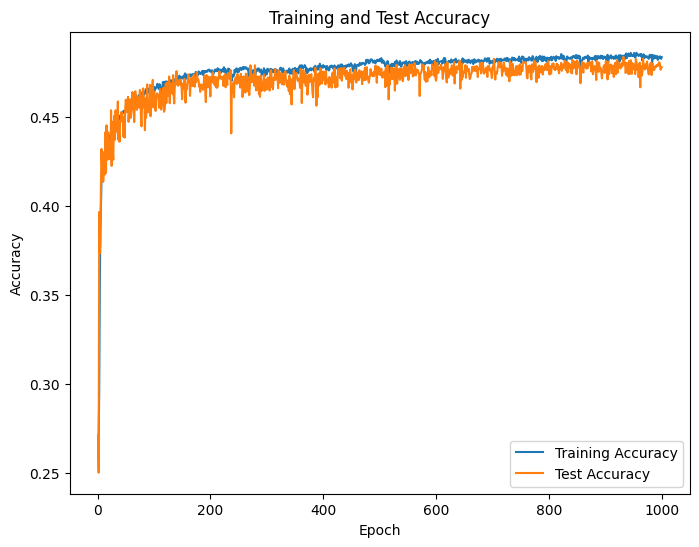

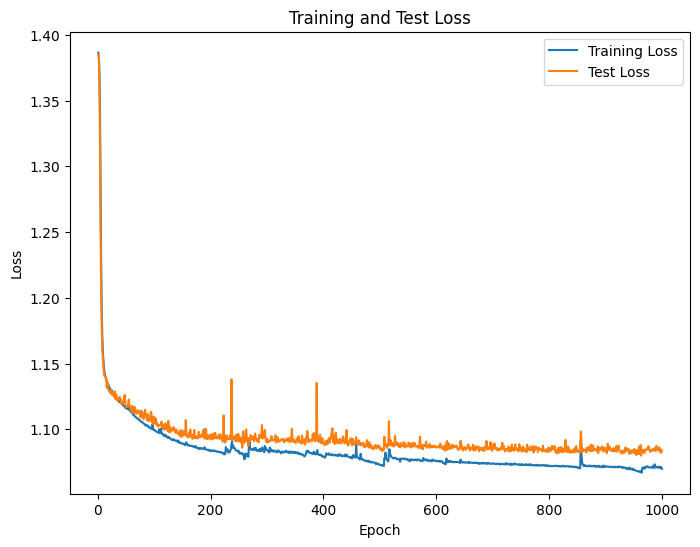

In [104]:
# Ambil histori akurasi dan loss dari proses pelatihan
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Buat plot untuk akurasi
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

# Buat plot untuk loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [105]:
# Evaluasi performa pada data latih
training_scores = model.evaluate(X_train, y_train)
print("Performa pada Data Latih:")
print("Loss:", training_scores[0])
print("Akurasi:", training_scores[1])

1860/1860 [==============================] - 5s 3ms/step - loss: 1.0702 - accuracy: 0.4859
Performa pada Data Latih:
Loss: 1.0701982975006104
Akurasi: 0.4859206974506378


In [106]:
# Evaluasi performa pada data uji
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss pada Data Uji:", loss)
print("Akurasi pada Data Uji:", accuracy)

465/465 [==============================] - 1s 3ms/step - loss: 1.0839 - accuracy: 0.4780
Loss pada Data Uji: 1.0838860273361206
Akurasi pada Data Uji: 0.47795698046684265


In [107]:
# Menghitung prediksi pada data uji
y_test_pred = model.predict(X_test)

465/465 [==============================] - 2s 2ms/step


In [108]:
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error

# metrik evaluasi untuk masalah regresi
print("Mean Squared Error:")
print(mean_squared_error(y_test, y_test_pred))

print("Mean Absolute Error:")
print(mean_absolute_error(y_test, y_test_pred))


Mean Squared Error:
0.15045133
Mean Absolute Error:
0.29949903


In [109]:
model.save('All.h5')

## Load Model

In [110]:
model = load_model('All.h5')

# Predict Datates

In [111]:
# Membaca dataset yang ingin diprediksi
predict_df = pd.read_csv('C:/Users/Afif Alaudin/Documents/GitHub/ta2023-boneusg/Data 6 Juli - Fix/LTSM/Process/50%/K502_processed.csv')
X_predict = predict_df.iloc[:].values

In [112]:
# Memprediksi label menggunakan model yang telah dilatih
y_pred_encoded = model.predict(X_predict)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_pred_label = label_encoder.inverse_transform(y_pred)

ValueError: in user code:

    File "c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Afif Alaudin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_5" is incompatible with the layer: expected shape=(None, 3, 1), found shape=(None, 2)


# Save Predict

In [ ]:
result_df = predict_df.copy()
result_df['predicted_label'] = y_pred_label
result_df.to_csv('data_predict_predicted.csv', index=False)

NameError: name 'y_pred_label' is not defined

# Result Predict

In [ ]:
print(result_df['predicted_label'].value_counts())

In [ ]:
# Membandingkan kemiripan label dengan dataset utama

similar_labels = []
for label in result_df['predicted_label'].unique():
    similarity = max(SequenceMatcher(None, label, unique_label).ratio() for unique_label in np.unique(y))
if similarity > 0.7:
    print("Data match :", label)

In [ ]:
Piye carane ben iso muncul 1 dataset tok